In [26]:
import numpy as np
import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
import torchvision as tv
import os

In [27]:
from torch.nn.functional import elu, dropout, log_softmax, nll_loss

In [28]:
use_gpu = True

if use_gpu:
    device = t.device('cuda:0')
else:
    device = t.device('cpu')

In [29]:
def dynamic_binarization(img):
    return t.distributions.bernoulli.Bernoulli(img).sample()

In [30]:
def bce_loss(x_real, x_rec):
    return t.sum(x_real * t.log(x_rec+1e-15) + (1 - x_real) * t.log(1 - x_rec + 1e-15))

In [31]:
def svgd_kernel(x):
    n = t.Tensor([x.size(0)]).to(device)
    assert n > 1
    
    norm = (x ** 2).sum(1).view(-1, 1)
    dist_mat = (norm + norm.view(1, -1)) - 2.0 * t.mm(x , x.t())
    
    h = t.median(dist_mat) / t.log(n)
    
    kxy = t.exp(- dist_mat / h)
    dxkxy = (-t.mm(kxy,x) + t.sum(kxy,1).view(-1,1)*x) / (2*h) 
    
    return kxy, dxkxy

In [115]:
path = '/T480/AnacondaProjects/svgd/'


train_data = tv.datasets.MNIST(path,train = True,download = True, transform = tv.transforms.Compose(
                                   [tv.transforms.CenterCrop(25),
                                    tv.transforms.ToTensor(),
                                    tv.transforms.Lambda(dynamic_binarization)]))
test_data = tv.datasets.MNIST(path,train = False, download = True, transform = tv.transforms.Compose(
                                   [tv.transforms.CenterCrop(25),
                                    tv.transforms.ToTensor(),
                                    tv.transforms.Lambda(dynamic_binarization)]))

In [33]:
class cnn_encoder(nn.Module):
    def __init__(self,n_hidden,input_dim, output_dim, drop_rate):
        super(cnn_encoder,self).__init__()
        self.drop_rate = drop_rate
        
        self.conv1 = nn.Conv2d(1,16,kernel_size = 5,stride = 2)
        self.conv2 = nn.Conv2d(16,32,kernel_size = 5,stride = 2)
        self.out = nn.Linear(n_hidden,output_dim)
        
    def forward(self,x):
        x = elu(self.conv1(x))
        x = dropout(x,self.drop_rate)
        x = elu(self.conv2(x))
        x = dropout(x,self.drop_rate)
        x = x.view(-1,512)
        x = self.out(x)
        return x
    
class cnn_decoder(nn.Module):
    def __init__(self,n_hidden,input_dim, output_dim, drop_rate):
        super(cnn_decoder,self).__init__()
        self.drop_rate = drop_rate

        self.input = nn.Linear(input_dim, n_hidden)
        self.deconv1 = nn.ConvTranspose2d(32,16,kernel_size = 5, stride = 2)
        self.deconv2 = nn.ConvTranspose2d(16,1,kernel_size = 5, stride = 2)
        
    def forward(self,x):
        x = self.input(x)
        x = dropout(x, self.drop_rate)
        x = x.view(-1,32,4,4)
        x = elu(self.deconv1(x))
        x = dropout(x,self.drop_rate)
        x = elu(self.deconv2(x))
        x = t.sigmoid(x)
        return x

In [34]:
class mlp_encoder(nn.Module):
    def __init__(self,n_hidden,input_dim, output_dim, drop_rate):
        super(mlp_encoder,self).__init__()
        
        self.drop_rate = drop_rate
        
        self.hidden = nn.Linear(input_dim,n_hidden)
        self.out = nn.Linear(n_hidden,output_dim)
    
    def forward(self,x):
        x = elu(self.hidden(x))
        x = dropout(x,self.drop_rate)
        x = self.out(x)
        return x
    
class mlp_decoder(nn.Module):
    def __init__(self,n_hidden,input_dim, output_dim, drop_rate):
        super(mlp_decoder,self).__init__()
        
        self.drop_rate = drop_rate
        
        self.hidden = nn.Linear(input_dim,n_hidden)
        self.out = nn.Linear(n_hidden, output_dim)
        
    def forward(self,x):
        x = elu(self.hidden(x))
        x = dropout(x,self.drop_rate)
        x = t.sigmoid(self.out(x))
        return x
    
class classifier(nn.Module):
    def __init__(self, n_hidden, input_dim, output_dim, drop_rate):
        super(classifier,self).__init__()
        
        self.drop_rate = drop_rate
        
        self.hidden = nn.Linear(input_dim, n_hidden)
        self.out = nn.Linear(n_hidden, output_dim)
    
    def forward(self,x):
        x = elu(self.hidden(x))
        x = dropout(x, self.drop_rate)
        x = log_softmax(self.out(x))
        return x

In [48]:
def train_svgd():
    encoder.train()
    decoder.train()
    for batch_index, (data,target) in enumerate(train_loader):
        encoder.zero_grad()
        decoder.zero_grad()
        
        img = data.repeat(n_parts,1,1,1).view(n_parts*batch_size_train, 1, 25,25).to(device)
        x = dropout(img, input_drop_rate)
        z = encoder(x).squeeze()
        
        z_for_grad = z.detach().to(device)
        z_for_grad.requires_grad = True
        x_rec = decoder(z_for_grad)

        logpxz = (-1/n_parts) * (bce_loss(img,x_rec)/batch_size_train)
        logpxz.backward()
        
        with t.no_grad():
            kzy, dzkzy = svgd_kernel(z_for_grad)
            phi = (t.mm(kzy,(-n_parts)*z_for_grad.grad - z_for_grad) + (1. + alpha) * dzkzy)/n_parts
            
        eta_grad = t.autograd.grad((-1/batch_size_train)*(phi * z).sum(), encoder.parameters())
        
        enc_opt.step()
        dec_opt.step()

In [294]:
input_drop_rate = 0.3
epochs = 10

batch_size_train = 30
batch_size_test = 1


alpha = 99
n_parts = 20
n_hidden = 512
latent_dim = 32
data_dim = [25,25]
model_drop_rate = 0.3


In [295]:
train_loader = t.utils.data.DataLoader(train_data,batch_size = batch_size_train, shuffle = True,pin_memory = use_gpu)
test_loader = t.utils.data.DataLoader(test_data,batch_size = batch_size_test, shuffle = True, pin_memory = use_gpu)

In [296]:
encoder = cnn_encoder(n_hidden,data_dim,latent_dim,model_drop_rate).to(device)
decoder = cnn_decoder(n_hidden,latent_dim,data_dim,model_drop_rate).to(device)

enc_opt = t.optim.Adam(encoder.parameters(), lr = 1e-4)
dec_opt = t.optim.Adam(decoder.parameters(), lr = 1e-4)
for ep in range(epochs):
    train_svgd()

In [361]:
with t.no_grad():
    encoder.eval()
    decoder.eval()
    data,target = next(iter(test_loader))
    x = data[0].repeat(n_parts,1,1,1).view(n_parts, 1,25,25).to(device)
    img = dropout(x, input_drop_rate)
    z = encoder(img)
    x_rec = decoder(z)

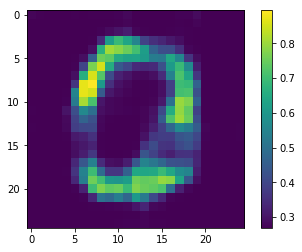

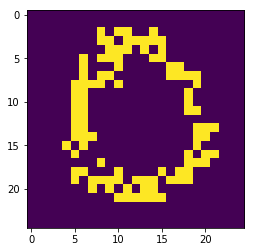

In [362]:
x = x.cpu()
x_rec = x_rec.cpu()
plt.imshow(x_rec[0].view(25,25))
plt.colorbar()
plt.figure()
plt.imshow(img[0].cpu().view(25,25))

In [ ]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with t.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.drop_rate = 0.3
        
        self.conv1 = nn.Conv2d(1,16,kernel_size = 5,stride = 2)
        self.conv2 = nn.Conv2d(16,32,kernel_size = 5,stride = 2)
        self.dense = nn.Linear(512,512)
        self.out = nn.Linear(512,10)
        
    def forward(self,x):
        x = elu(self.conv1(x))
        x = dropout(x,self.drop_rate)
        x = elu(self.conv2(x))
        x = dropout(x,self.drop_rate)
        x = x.view(-1,512)
        x = elu(self.dense(x))
        x = dropout(x,self.drop_rate)
        x = log_softmax(self.out(x))
        return x

In [ ]:
network = CNN()
optimizer = t.optim.Adam(network.parameters())

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

test()
for epoch in range(1,n_epochs + 1):
    train(epoch)
    test()
    
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
